In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [2]:
data = pd.read_csv('mnist.csv', header = None)
label = data.iloc[:,[0]].copy().values
X = data.drop(columns = 0).copy().values
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [3]:
class Cluster:
    def __init__(self, name, centre):
        self.name = name
        self.centre = centre
        self.members = []

    def set_centre(self, centre):
        self.centre = centre
    
    def add_member(self, datapoint):
        self.members.append(datapoint)
        
    def calculate_new_centre(self):
        members = np.array(self.members)
        sum_members = np.sum(members, axis = 0)
        new_mean = sum_members/len(members)
        self.centre = new_mean
        
    def reset(self):
        self.members = []
    
    def __repr__(self):
        return str(self.centre)

In [6]:
def collapse_labels(M):
    labels = []
    for row in M:
        for i in range(len(row)):
            if row[i] == 1:
                labels.append(i)
                break
    return np.array(labels)

# Question 4

In [40]:
def initialise(X, k, random_state = 69):
    # initialise cluster centres
    np.random.seed(random_state)
    N = len(X)
    
    initial_centres = np.random.randint(low = 0, high = N, size = k)

    clusters = {}
    for each_k in range(k):
        clusters[each_k] = Cluster(each_k, X[initial_centres[each_k]])

    # initialise r
    r = np.zeros((N, k))

    for i in range(N):
        initial_assignment = np.random.randint(low = 0, high = k)
        r[i, initial_assignment] = 1
        
    return clusters, r

In [41]:
def train(X_train, r, clusters):
    max_iter = 100
    N = len(X_train)
    
    for niter in range(max_iter):
        r_new = []
        
        for i in range(N):
            distance_ls = []

            for each_cluster in clusters:

                # calculate distance between X_i and cluster centre k
                d_ik = np.linalg.norm(X_train[i]-clusters[each_cluster].centre)**2
                distance_ls.append(d_ik)

            new_label = distance_ls.index(np.min(distance_ls))
            clusters[new_label].add_member(X_train[i])

            distance_ls = np.array(distance_ls)
            new_assignment_for_i = (distance_ls == np.min(distance_ls))
            r_new.append(new_assignment_for_i)

        if np.allclose(r, r_new):
            print(niter, 'done')
            break

        r = r_new

        for each_cluster in clusters:
            clusters[each_cluster].calculate_new_centre()
            clusters[each_cluster].reset()
        
    return clusters

In [84]:
def validate(X_val, clusters):
    print('validating...')
    
    for each_cluster in clusters:
        clusters[each_cluster].reset()
        
    N = len(X_val)
    loss = 0
    labels = []
    
    for i in range(N):
        distance_ls = []

        for each_cluster in clusters:
            # calculate distance between X_i and cluster centre k
            d_ik = np.linalg.norm(X_val[i]-clusters[each_cluster].centre)**2
            distance_ls.append(d_ik)
            
        new_label = distance_ls.index(np.min(distance_ls))
        labels.append(new_label)

        loss_i = distance_ls[new_label]
        
        loss += loss_i
        
    labels = np.array(labels)
    
    # calculate silhouette 
    k = len(clusters)
    silhouette_scores = []
    silhouette_by_group = {}
    
    for i in range(N):
        label_i = labels[i]
        all_dist = np.linalg.norm(X_val[i] - X_val, axis = 1)
        from_same_cluster = (labels == label_i)

        a_i = np.sum(all_dist[from_same_cluster]) / (len(all_dist[from_same_cluster])-1)
        
        b_i = float('inf')

        for each_k in range(k):
            if each_k != label_i:
                from_k = (labels == each_k)
                dist_from_i_to_members_of_k = all_dist[from_k]
                if np.mean(dist_from_i_to_members_of_k) < b_i:
                    b_i = np.mean(dist_from_i_to_members_of_k)

        s_i = (b_i - a_i)/max(a_i, b_i)
        
        if label_i not in silhouette_by_group:
            silhouette_by_group[label_i] = []
        silhouette_by_group[label_i].append(s_i)    
        silhouette_scores.append(s_i)
        
    avg_silhouette = np.mean(silhouette_scores)
    
    plot_silhouette_scores(len(clusters), silhouette_by_group, avg_silhouette)
        
    return loss, avg_silhouette

plot code from https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

In [91]:
def plot_silhouette_scores(k, silhouette_by_group, avg_silhouette):
    
    plt.rcParams["figure.figsize"] = (9,7)
    plt.xlim([-0.2, 1])
    plt.title('Silhouette analysis with n_clusters = {}'.format(k))

    y_lower = 10
    for i in range(k):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = np.array(silhouette_by_group[i])

        ith_cluster_silhouette_values.sort()
        #print(ith_cluster_silhouette_values)

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / k)
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10

    # The vertical line for average silhouette score of all the values
    plt.axvline(x=avg_silhouette, color="red", linestyle="--")
    plt.show()

In [92]:
X_train = X[:4000]
X_val = X[4000:]

5: training
27 done
validating...


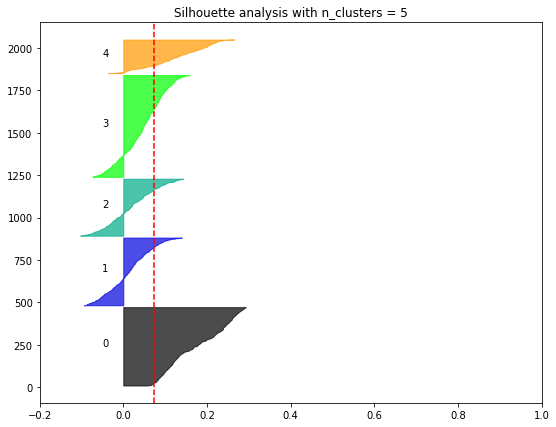

5: done, loss = 88529.58, avg sillhouette = 0.0726

6: training
13 done
validating...


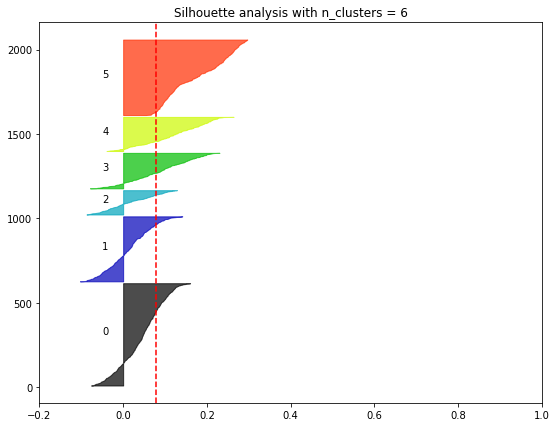

6: done, loss = 86911.93, avg sillhouette = 0.0778

7: training
18 done
validating...


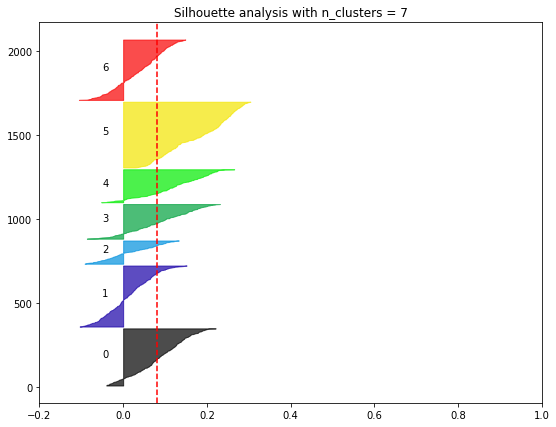

7: done, loss = 84163.84, avg sillhouette = 0.0807

8: training
37 done
validating...


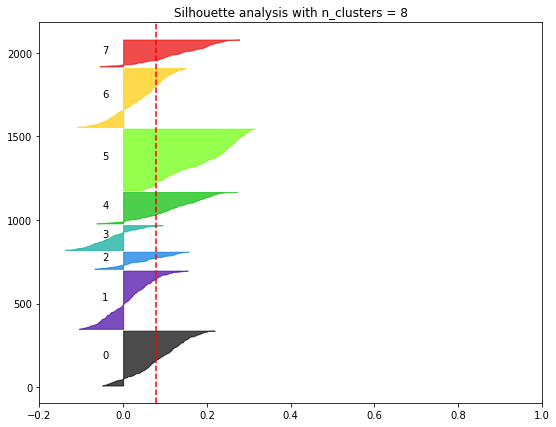

8: done, loss = 83106.94, avg sillhouette = 0.0793

9: training
22 done
validating...


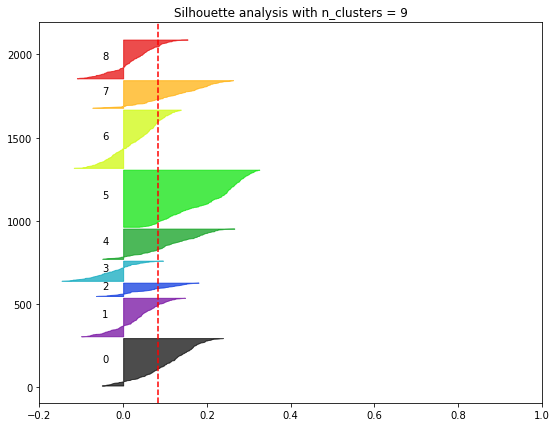

9: done, loss = 81366.24, avg sillhouette = 0.0831

10: training
26 done
validating...


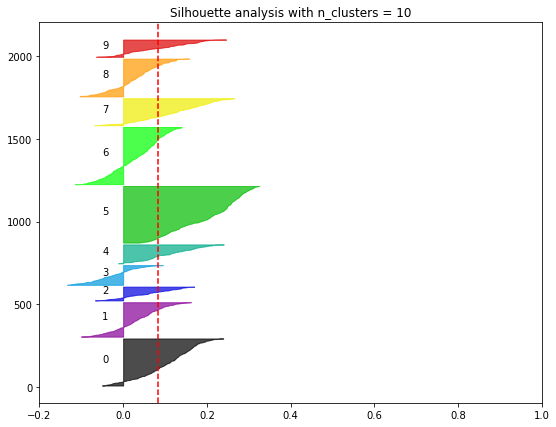

10: done, loss = 80146.92, avg sillhouette = 0.0830

11: training
33 done
validating...


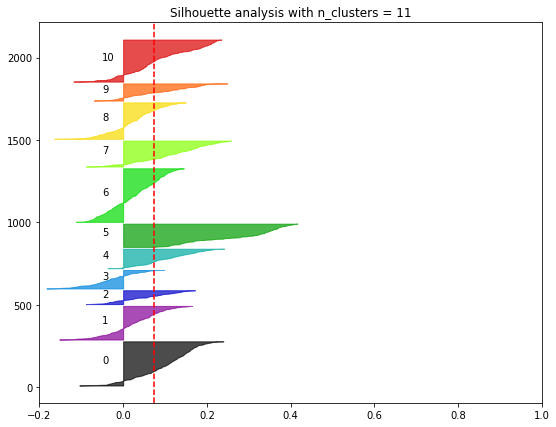

11: done, loss = 78322.85, avg sillhouette = 0.0727

12: training
24 done
validating...


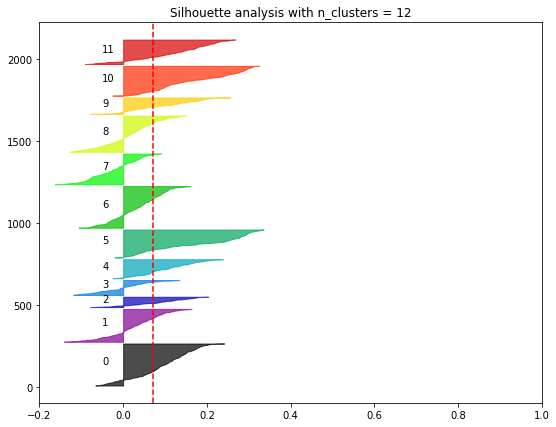

12: done, loss = 77489.01, avg sillhouette = 0.0707

13: training
29 done
validating...


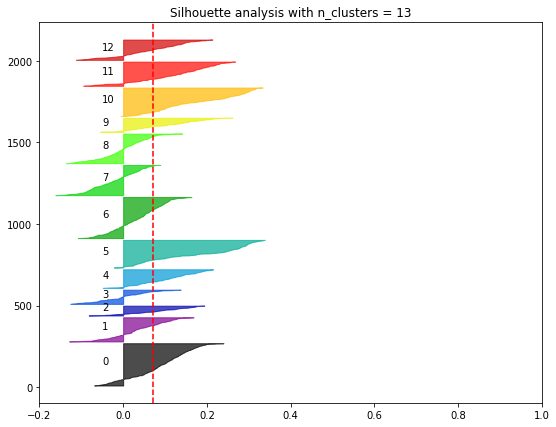

13: done, loss = 76562.92, avg sillhouette = 0.0720

14: training
29 done
validating...


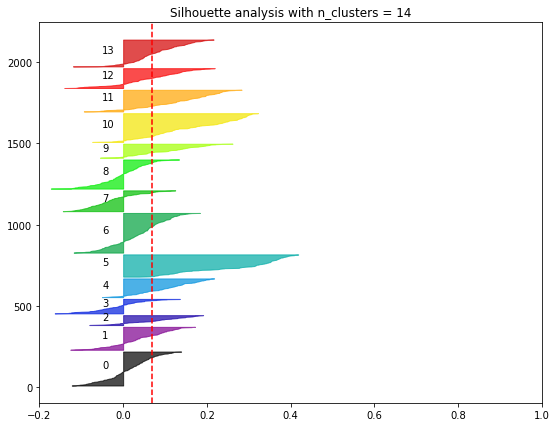

14: done, loss = 75827.21, avg sillhouette = 0.0701

15: training
30 done
validating...


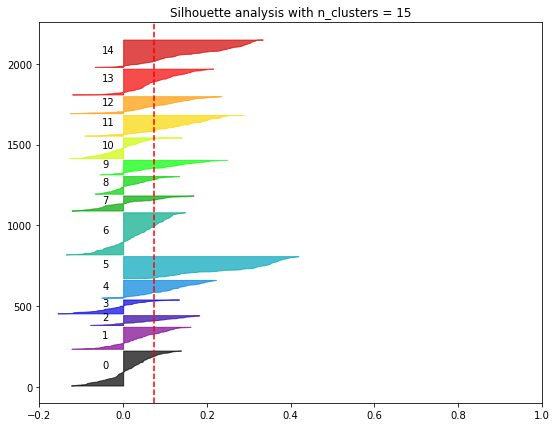

15: done, loss = 75027.32, avg sillhouette = 0.0730

16: training
37 done
validating...


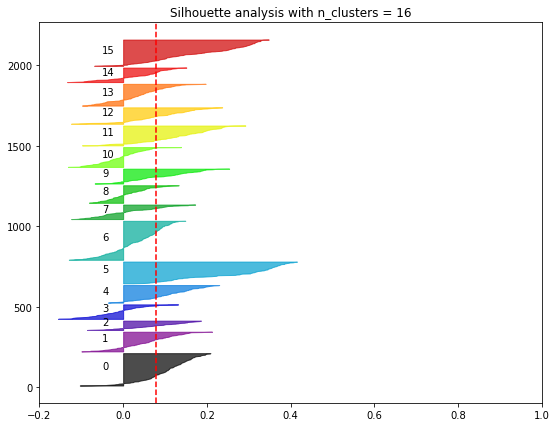

16: done, loss = 73965.34, avg sillhouette = 0.0789

17: training
32 done
validating...


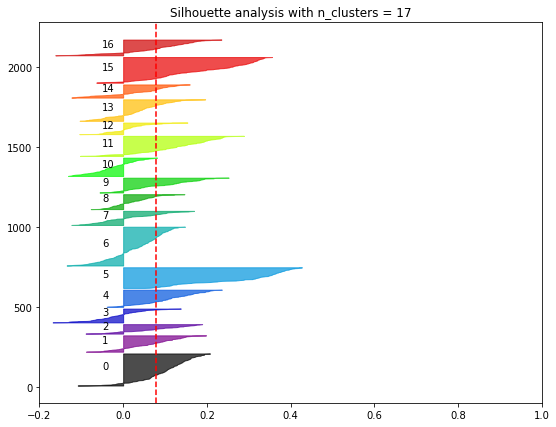

17: done, loss = 73700.70, avg sillhouette = 0.0780

18: training
33 done
validating...


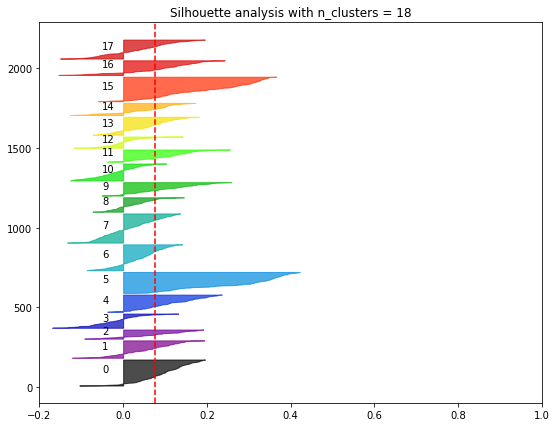

18: done, loss = 72852.10, avg sillhouette = 0.0753

19: training
27 done
validating...


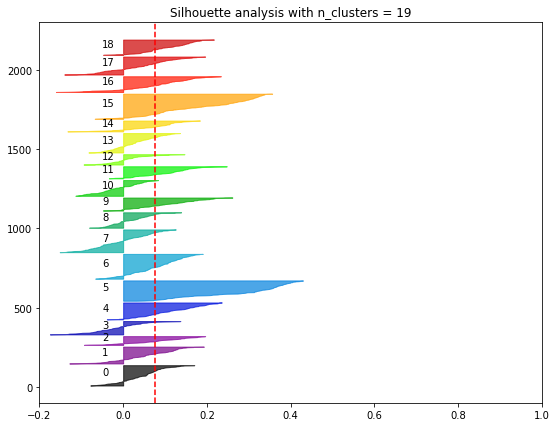

19: done, loss = 72028.09, avg sillhouette = 0.0756

20: training
40 done
validating...


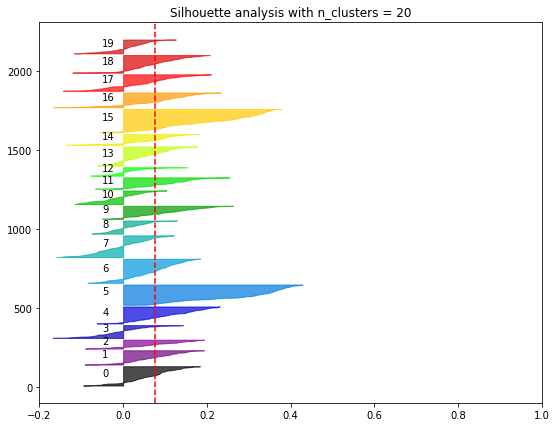

20: done, loss = 71547.18, avg sillhouette = 0.0770



In [94]:
loss_by_k = []
silhouette_scores_by_k = []

for k in range(5, 21):
    print('{}: training'.format(k))
    clusters, r = initialise(X_train, k=k, random_state = 1)
    new_clusters = train(X_train, r, clusters)
    loss, avg_silhouette = validate(X_val, new_clusters)
    loss_by_k.append(loss)
    silhouette_scores_by_k.append(avg_silhouette)
    print('{}: done, loss = {:.2f}, avg sillhouette = {:.4f}\n'.format(k, loss, avg_silhouette))


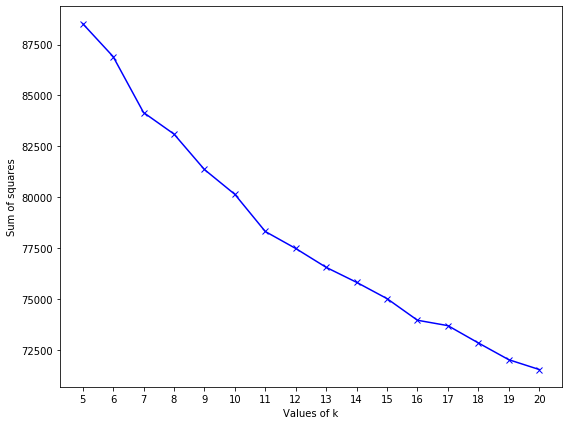

In [95]:
k_range = np.arange(5, 21)
plt.plot(k_range, loss_by_k, color = 'blue', marker = 'x')
plt.ylabel('Sum of squares')
plt.xlabel('Values of k')
plt.xticks(k_range)
plt.show()

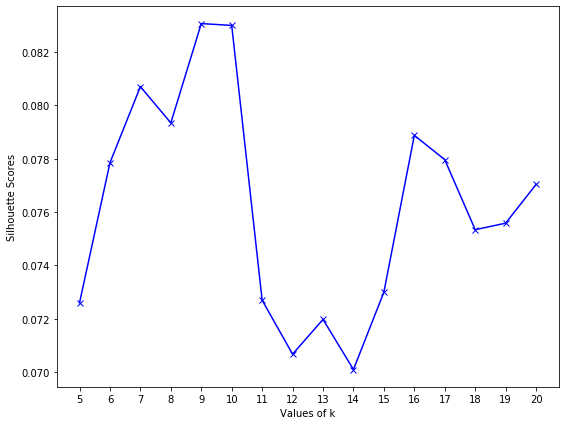

In [96]:
plt.plot(k_range, silhouette_scores_by_k, color = 'blue', marker = 'x')
plt.ylabel('Silhouette Scores')
plt.xlabel('Values of k')
plt.xticks(k_range)
plt.show()